<a href="https://colab.research.google.com/github/wushidiguo/keras-notes/blob/master/class_activation_map(CAM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.applications.vgg16 import VGG16
# 呀！这次不是topless了。
model = VGG16(weights="imagenet")

Using TensorFlow backend.






553467904/553467096 [==============================] - 12s 0us/step








In [0]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

In [3]:
from google.colab import files
files.upload()

Saving images.jpg to images.jpg


{'images.jpg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x13\x12\x12\x15\x13\x12\x12\x15\x15\x15\x16\x17\x18\x18\x17\x18\x18\x15\x17\x17\x18\x17\x17\x18\x18\x18\x18\x18\x18\x18\x17\x18\x1d( \x18\x1a%\x1b\x18\x18!1!%)+...\x18\x1f383-7(-.+\x01\n\n\n\x0e\r\x0e\x17\x10\x10\x17-\x1d\x17\x1d+---------++----------+------------7--------+---77\xff\xc0\x00\x11\x08\x01\xc4\x02\xa6\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x00\x02\x03\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x01\x02\x04\x05\x06\x07\x08\xff\xc4\x00B\x10\x00\x01\x03\x03\x02\x03\x05\x06\x04\x05\x04\x02\x01\x04\x03\x01\x01\x00\x02\x11\x03!1\x12A\x04Qa"q\x81\x91\xa1\x05\x132\xb1\xc1\xf0\x06B\xd1\xe1\x07\x14Rb\xf1#r\x82\x923\xb2\xa2\x15$C\xd2S\x93\xc2\x16\xff\xc4\x00\x19\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\xff\xc4\x00&\x11\x01\x01\x01\x00\x01\x04\x02\x02\x03\x01\x00\x03\x00\x00\x00\x00\x00\

In [0]:
img_path = "images.jpg"

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
# vgg16的神秘预处理
x = preprocess_input(x)

In [0]:
# 此处preds是个(1, 1000)的numpy数组。
preds = model.predict(x)

In [10]:
# decode_predictions返回一个数组之数组。
decode_predictions(preds, top=3)[0]

[('n02504458', 'African_elephant', 0.86854166),
 ('n01871265', 'tusker', 0.1216799),
 ('n02504013', 'Indian_elephant', 0.009099626)]

In [11]:
np.argmax(preds[0])

386

In [0]:
# Grad-CAM
import keras.backend as K
african_elephant_output = model.output[:, 386]
# "block5_conv3"的输出的形状是(None, 14, 14, 512)
last_conv_layer = model.get_layer("block5_conv3")
# 因为gradients接收一个loss和一个变量的list，因此返回值是一个list。
# grads---(1, 14, 14, 512)
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
# pooled_grads---(512,)，代表着每个channel的重要性——即对正确结果的影响。
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
# pooled_grad_value---(512,); conv_layer_output_value---(14, 14, 512)
pooled_grads_value, conv_layer_output_value = iterate([x])
# 将pooled_grads作为权重，对512个通道的输出进行平均，所得结果即是class activation的热图。
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output_value, axis=-1)

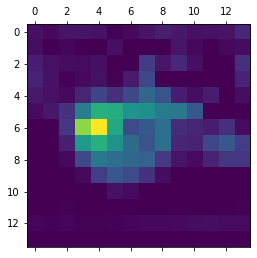

In [39]:
import matplotlib.pyplot as plt
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [40]:
import cv2
img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite("drive/My Drive/Colab Notebooks/elephat_cam.jpg", superimposed_img)

True

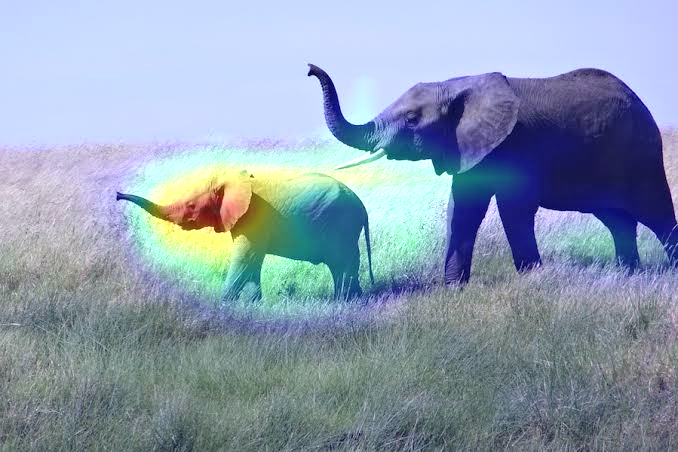

In [41]:
from google.colab.patches import cv2_imshow
cv2_imshow(superimposed_img)